In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, TrainingArguments, AutoModelForSequenceClassification
import torch

from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

/home/lb4489/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_path = "/scratch/lb4489/LLM"

# Import the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref", cache_dir=model_path, trust_remote_code=True)
model = AutoModelForMaskedLM.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref", cache_dir=model_path, trust_remote_code=True)

In [ ]:
#试一下human的500m会不会比多物种的好一些,但是然而并没有什么区别，感觉在validate set上还差一点，更容易过拟合了？

In [3]:
num_labels_promoter = 3

# Load the model

model = AutoModelForSequenceClassification.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-500m-multi-species", num_labels=num_labels_promoter, cache_dir=model_path)

The repository for InstaDeepAI/nucleotide-transformer-v2-500m-multi-species contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/InstaDeepAI/nucleotide-transformer-v2-500m-multi-species.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y
The repository for InstaDeepAI/nucleotide-transformer-v2-500m-multi-species contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/InstaDeepAI/nucleotide-transformer-v2-500m-multi-species.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-500m-multi-species were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-500m-multi-species and are newly initialized: ['classifier.dense.bias', 

In [4]:
import pandas as pd

# 读取 TSV 文件
df = pd.read_csv("/scratch/lb4489/project/mttRNA/trainset.csv", sep=",")

# 显示前几行
print(df.head())

                                                 seq  label
0  TTTTCTTCGCAGGATTTTTCTGAGCCTTTTACCACTCCAGCCTAGC...      1
1  AGGCTGCTGCTGAGAAGGCAGTGACCAAGGAGGAATTTCAGGGTGA...      1
2  ATTAGGAGGGCACTGGCCCCCAACAGGCATCACCCCGCTAAATCCC...      1
3  GTGGCGCTGGGGTTGGCTCCATGACCAAGATCTATGGGGGACGTCA...      1
4  TATTCTTGGCAGAGGCTACGGAAACAGGCCGAGAAGAACGTGGAGA...      1


In [5]:
df_selected = df

In [6]:
print(df_selected["label"].value_counts())

label
0    9438
1    9139
2    3136
Name: count, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset

In [8]:
df_selected.columns = ["data", "label"]  
df_selected["label"] = df_selected["label"].astype(int)

train_data, val_data, train_labels, val_labels = train_test_split(
    df_selected["data"], df_selected["label"], test_size=0.2, random_state=42
)

ds_train = Dataset.from_dict({"data": train_data.tolist(), "label": train_labels.tolist()})
ds_validation = Dataset.from_dict({"data": val_data.tolist(), "label": val_labels.tolist()})

print(ds_train)
print(ds_validation)

Dataset({
    features: ['data', 'label'],
    num_rows: 17370
})
Dataset({
    features: ['data', 'label'],
    num_rows: 4343
})


In [9]:
def tokenize_function(examples):
    outputs = tokenizer(examples["data"])
    return outputs

In [10]:
tokenized_datasets_train = ds_train.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)
tokenized_datasets_validation = ds_validation.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)

Map: 100%|██████████| 4343/4343 [00:01<00:00, 2596.73 examples/s]


In [11]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, recall_score
from transformers import TrainingArguments, Trainer

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # 计算 Accuracy, F1-score, Recall
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")

    return {
        "accuracy": acc,
        "f1_score": f1
    }


In [12]:
device = torch.device("cuda")
model = model.to(device)

In [13]:
batch_size = 16
model_name='nucleotide-transformer'
args_promoter = TrainingArguments(
    f"{model_name}-finetuned-NucleotideTransformer",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps= 1,
    per_device_eval_batch_size= 64,
    num_train_epochs= 2,
    logging_steps= 100,
    load_best_model_at_end=True,  # Keep the best model according to the evaluation
    metric_for_best_model="f1_score",
    label_names=["labels"],
    dataloader_drop_last=True,
    max_steps= 3000,
    weight_decay=0.01,  #gpt给的三个参数还挺重要的，能让表现提升
    lr_scheduler_type="linear", 
    warmup_ratio=0.1,
)

/home/lb4489/.local/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
trainer = Trainer(
    model.to(device),
    args=args_promoter,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_validation,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # 使用新的 metrics 计算函数
)

/tmpdata/ipykernel_3461313/1959967892.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [15]:
trainer.train() 
trainer.evaluate()

Step,Training Loss,Validation Loss,Accuracy,F1 Score
100,1.039400,0.977491,0.544543,0.500769
200,0.926800,0.902157,0.600513,0.555827
300,0.862700,0.746045,0.705924,0.654162
400,0.720400,0.665768,0.740905,0.687377
500,0.629800,0.659735,0.737640,0.693454
600,0.576900,0.586395,0.770522,0.732681
700,0.588900,0.569857,0.784049,0.777136
800,0.562000,0.591027,0.774021,0.729204
900,0.548200,0.534387,0.798041,0.775174
1000,0.506500,0.523659,0.802705,0.775412


Could not locate the best model at nucleotide-transformer-finetuned-NucleotideTransformer/checkpoint-2900/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


{'eval_loss': 0.46575701236724854,
 'eval_accuracy': 0.8687033582089553,
 'eval_f1_score': 0.8623716170809165,
 'eval_runtime': 10.4235,
 'eval_samples_per_second': 416.655,
 'eval_steps_per_second': 6.524,
 'epoch': 2.7649769585253456}

In [16]:
curve_evaluation_f1_score = [[a['step'], a['eval_f1_score']] for a in trainer.state.log_history if 'eval_f1_score' in a]

curve_evaluation_accuracy = [[a['step'], a['eval_accuracy']] for a in trainer.state.log_history if 'eval_accuracy' in a]


eval_f1_score = [c[1] for c in curve_evaluation_f1_score]
eval_accuracy = [c[1] for c in curve_evaluation_accuracy]

steps = [c[0] for c in curve_evaluation_f1_score] 

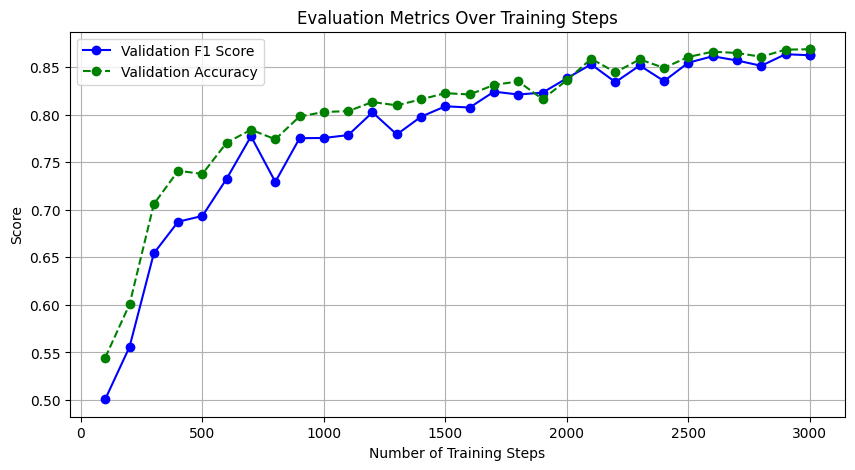

In [17]:
plt.figure(figsize=(10, 5))

plt.plot(steps, eval_f1_score, 'b', marker="o", linestyle="-", label='Validation F1 Score')

plt.plot(steps, eval_accuracy, 'g', marker="o", linestyle="--", label='Validation Accuracy')

plt.title('Evaluation Metrics Over Training Steps')
plt.xlabel('Number of Training Steps')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.show()

In [18]:
dfv = pd.read_csv("/scratch/lb4489/project/mttRNA/valiset.csv", sep=",")
dfv.columns = ["data", "label"] 
dfv["label"] = dfv["label"].astype(int)  

ds_validation = Dataset.from_pandas(dfv)

In [19]:
tokenized_datasets_vali = ds_validation.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)

Map: 100%|██████████| 2463/2463 [00:00<00:00, 2595.10 examples/s]


In [20]:
predictions = trainer.predict(tokenized_datasets_vali)


In [21]:
logits = predictions.predictions
probs = torch.softmax(torch.tensor(logits), dim=-1)
predicted_labels = torch.argmax(probs, dim=-1).numpy()

# 得到了一个三分类的概率矩阵
print(probs)

tensor([[7.0841e-04, 9.9756e-01, 1.7350e-03],
        [9.0283e-04, 9.9772e-01, 1.3794e-03],
        [8.9843e-04, 9.9745e-01, 1.6466e-03],
        ...,
        [7.6378e-01, 1.3632e-01, 9.9909e-02],
        [5.9180e-01, 4.7002e-03, 4.0350e-01],
        [9.2876e-01, 2.8183e-02, 4.3059e-02]])


In [22]:

logits, labels = predictions.predictions, predictions.label_ids

results = compute_metrics((logits, labels))
print(results)


{'accuracy': 0.7734375, 'f1_score': 0.773221231898055}


In [23]:
#两项指标要比testset低一点点，但感觉完全能接受了

In [24]:
trainer.save_model("/scratch/lb4489/LLM/MY_model")
tokenizer.save_pretrained("/scratch/lb4489/LLM/MY_model")

('/scratch/lb4489/LLM/MY_model/tokenizer_config.json',
 '/scratch/lb4489/LLM/MY_model/special_tokens_map.json',
 '/scratch/lb4489/LLM/MY_model/vocab.txt',
 '/scratch/lb4489/LLM/MY_model/added_tokens.json')

In [ ]:
#from transformers import AutoModelForSequenceClassification, AutoTokenizer

#model = AutoModelForSequenceClassification.from_pretrained("./my_trained_model")
#tokenizer = AutoTokenizer.from_pretrained("./my_trained_model")
#如果下次使用的话